In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(200),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(40),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), shear=0.2, scale=(0.8, 1.2)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize(200),
        transforms.CenterCrop(200),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

# Load datasets
train_dataset = datasets.ImageFolder('new_dataset/train_data/', data_transforms['train'])
val_dataset = datasets.ImageFolder('new_dataset/val_data/', data_transforms['val'])

# Split datasets for validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, _ = random_split(train_dataset, [train_size, val_size])

_, val_size = random_split(val_dataset, [val_size, len(val_dataset) - val_size])

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

# Define the model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv5 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = x.view(-1, 64 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

model = Net().to(device)

# Define loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

train_losses = []
val_losses = []
val_accuracies = []

# Training loop
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    
    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            
            predicted = torch.round(outputs)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(train_loader.dataset)
    val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")


Epoch 1/15, Train Loss: 0.5594, Val Loss: 0.3134, Val Accuracy: 86.79%
Epoch 2/15, Train Loss: 0.4320, Val Loss: 0.3243, Val Accuracy: 83.57%
Epoch 3/15, Train Loss: 0.3891, Val Loss: 0.3621, Val Accuracy: 87.50%
Epoch 4/15, Train Loss: 0.4165, Val Loss: 0.3146, Val Accuracy: 85.00%
Epoch 5/15, Train Loss: 0.3979, Val Loss: 0.2960, Val Accuracy: 86.43%
Epoch 6/15, Train Loss: 0.3865, Val Loss: 0.3404, Val Accuracy: 84.64%
Epoch 7/15, Train Loss: 0.3805, Val Loss: 0.2728, Val Accuracy: 90.36%
Epoch 8/15, Train Loss: 0.3558, Val Loss: 0.2871, Val Accuracy: 86.79%
Epoch 9/15, Train Loss: 0.3642, Val Loss: 0.2926, Val Accuracy: 86.07%
Epoch 10/15, Train Loss: 0.3548, Val Loss: 0.2829, Val Accuracy: 88.57%
Epoch 11/15, Train Loss: 0.3461, Val Loss: 0.3812, Val Accuracy: 86.79%
Epoch 12/15, Train Loss: 0.3417, Val Loss: 0.2925, Val Accuracy: 88.57%
Epoch 13/15, Train Loss: 0.3303, Val Loss: 0.3032, Val Accuracy: 87.14%
Epoch 14/15, Train Loss: 0.3363, Val Loss: 0.2481, Val Accuracy: 90.36%
E

In [19]:
# Define the transform for the test set
test_transforms = transforms.Compose([
    transforms.Resize(200),
    transforms.CenterCrop(200),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load the test dataset
test_dataset = datasets.ImageFolder('new_dataset/test_data/', test_transforms)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [20]:
# Test the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
        
        outputs = model(inputs)
        predicted = torch.round(outputs)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 85.36%


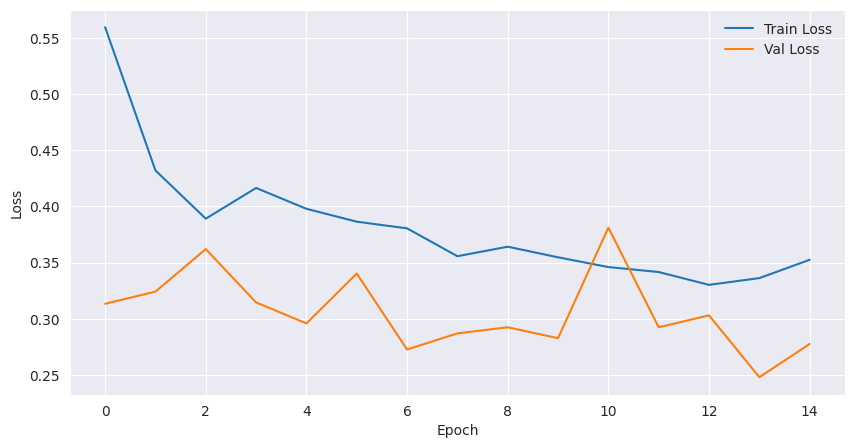

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(frameon=False)
plt.show()


In [22]:
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}
file_path = 'model_checkpoint.pth'
torch.save(checkpoint, file_path)

In [23]:
#create confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

model.eval()
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)

        outputs = model(inputs)
        predicted = torch.round(outputs)
        
        y_pred_list.append(predicted.cpu().numpy())
        y_true_list.append(labels.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
y_true_list = [a.squeeze().tolist() for a in y_true_list]


print(y_pred_list)
print(y_true_list)
 

[0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0,

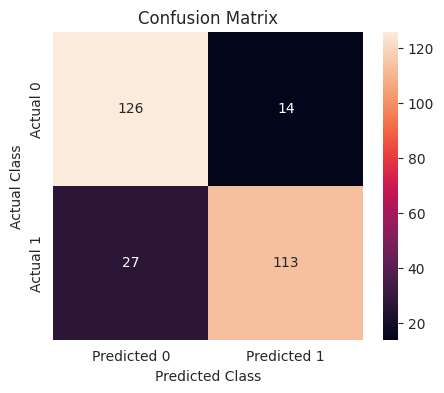

In [24]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list, y_pred_list)).rename(columns={0: 'Predicted 0', 1: 'Predicted 1'}, index={0: 'Actual 0', 1: 'Actual 1'})
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix_df, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()